# 🔰PyTorchでニューラルネットワーク基礎 #06【中間層特徴量の抽出】

* [Qiita](https://qiita.com/AzukiImo/items/c19bc36a613a6f1caf00)の記事と連動しています
* ネットワークなどの基本構造はsample_05.ipynbと同一
* データファイル: aiueo.npz
* データファイルの保存先: dataフォルダ

In [1]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import japanize_matplotlib

In [2]:
#デバイスの選択
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using Device Name:", device)

Using Device Name: cuda:0


In [3]:
# 精度を計算する関数
def accuracy(y, t):
    _, argmax_list = torch.max(y, dim=1)
    accuracy = sum(argmax_list == t).item()/len(t)
    return accuracy

In [4]:
data = np.load("./data/aiueo.npz")
x = data["x"]
t = data["t"]

# torchテンソルに変換
x = torch.FloatTensor(x).to(device)
t = torch.LongTensor(t).to(device)

x, x_test, t, t_test = train_test_split(x,t, test_size=0.1, random_state=55)

In [5]:
x.shape, x_test.shape, t.shape

(torch.Size([712, 1, 28, 28]), torch.Size([80, 1, 28, 28]), torch.Size([712]))

## 確認ポイント
1. カーネルサイズと出力後の形状
2. out_channelsの効果
3. flatten
4. Linearのin_featuresの計算方法
5. 活性化関数の引数
   * nn.LeakyReLU()の場合は、\_\_init__ 内でオプションを指定
   * F.leaky_relu()の場合は、forward()で使うときに、 l_relu(h, negative_slope=0.01)と使用時にオプションを記入
     

In [6]:
##### モデル定義
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=5 ,kernel_size=5)
        self.act1 = nn.LeakyReLU(negative_slope=0.01)  # Leaky ReLU導入
        self.pool1= nn.MaxPool2d(kernel_size=2, stride=2)

        self.flat = nn.Flatten()
        self.fc1 =  nn.Linear(in_features=5*12*12, out_features=100)
        self.act2 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=100, out_features=5)
        
    def forward(self, x):
        h = self.cnn1(x)
        h = self.act1(h)
        h = self.pool1(h)
        h = self.flat(h)
        h = self.fc1(h)
        h = self.act2(h)
        y = self.fc2(h)
        return y

In [7]:
model = DNN()
model.to(device)

DNN(
  (cnn1): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
  (act1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=720, out_features=100, bias=True)
  (act2): ReLU()
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)

In [8]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()   
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [9]:
# 機械学習
LOOP = 300
for epoch in range(LOOP):
    optimizer.zero_grad()
    y = model(x)
    loss = criterion(y, t)
    acc  = accuracy(y,t)
    loss.backward()
    optimizer.step()
    if (epoch+1)%50 == 0:
        print(f"{epoch}: loss: {loss.item()}, acc: {acc}")  # バッチ全体での損失や精度

49: loss: 0.6073104739189148, acc: 0.8932584269662921
99: loss: 0.3157322108745575, acc: 0.9311797752808989
149: loss: 0.22354601323604584, acc: 0.9536516853932584
199: loss: 0.15911154448986053, acc: 0.9662921348314607
249: loss: 0.10984654724597931, acc: 0.9747191011235955
299: loss: 0.07371295988559723, acc: 0.9845505617977528


In [11]:
model.eval()
y_test = model(x_test)
test_acc = accuracy(y_test, t_test)
print(f"精度:{test_acc}")

精度:0.975


## 特徴量の可視化

# register_forward_hookを利用した中間層の特徴量抽出

https://docs.pytorch.org/docs/stable/notes/modules.html

### CNNとPOOLの出力

In [37]:
# 中間層の出力を保存するための辞書
# {ネットワーク名: ネットワーク名の出力値,...}
feature_maps = {}

# module: ネットワーク層 nn.Linear，nn.Conv2d
# input: moduleに入力される値 画像だと（b, c, h, w)
# output: moduleの出力値 画像だと CNN出力の(b, c, h, w)
# hook関数の名前は何でもよいが、引数は必ず、module, input, outputの3種類（x,y,z)でもOK
def register_activation_hook(name):
    """
    アクティベーション（中間層出力）を取得するためのフック関数を返す 
    Parameters:
        name (str): 層の識別名（辞書のキーとして使用）
    Returns:
        function: PyTorchのフォワードフック関数　register_activation_hookの引数になる
    """
    def hook(module, input, output):
        feature_maps[name] = output.detach()
    return hook

# 抽出するネットワーク名を登録する
hooks = []
hooks.append(model.cnn1.register_forward_hook(register_activation_hook("cnn1")))
hooks.append(model.act1.register_forward_hook(register_activation_hook("act1")))
hooks.append(model.pool1.register_forward_hook(register_activation_hook("pool1")))

In [39]:
model.eval()
# テスト用の一つの画像を選択
# あ：300, い：500　う：200 え：600　お:100
sample_image = x[500].unsqueeze(0)  # バッチ次元を追加 (1, 1, 28, 28)

with torch.no_grad():
    output = model(sample_image)
print(output)

# 確認のためにキーと形状を表示するコードを追加すると良い
for layer_name, feature_map in feature_maps.items():
    print(f"{layer_name}: {feature_map.shape}")

tensor([[-2.4911,  5.7498, -0.9894, -1.5190, -1.0798]], device='cuda:0')
cnn1: torch.Size([1, 5, 24, 24])
act1: torch.Size([1, 5, 24, 24])
pool1: torch.Size([1, 5, 12, 12])


## CNNの出力値の可視化
* feature_maps["cnn1"]がCNNの出力値

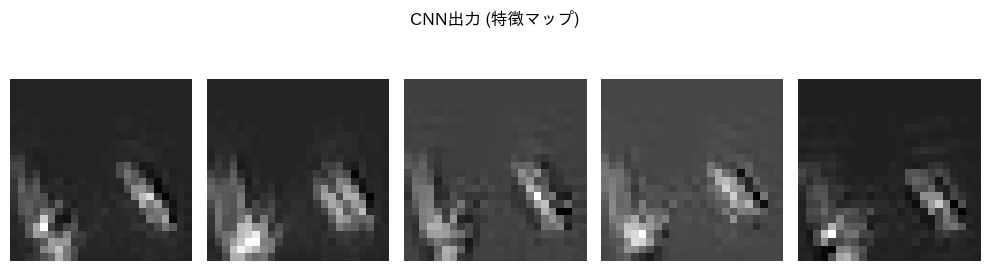

In [40]:
cnn_feature_map = feature_maps["cnn1"].squeeze().cpu().numpy()

fig, axes = plt.subplots(1, 5, figsize=(10, 3))
plt.suptitle('CNN出力 (特徴マップ)')
for i, ax in enumerate(axes.flat):
    ax.imshow(cnn_feature_map[i], cmap="gray")
    ax.axis('off')
plt.tight_layout()
plt.show()

## プーリング層の出力値の可視化
* feature_maps["pool1"]がCNNの出力値

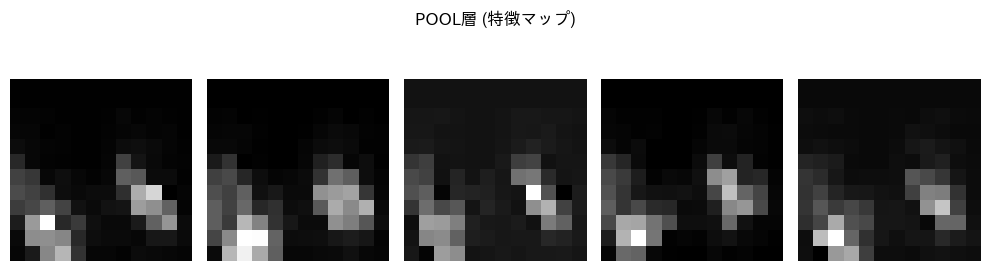

In [41]:
pool_feature_map = feature_maps["pool1"].squeeze().cpu().numpy()

fig, axes = plt.subplots(1, 5, figsize=(10, 3))
plt.suptitle('POOL層 (特徴マップ)')
for i, ax in enumerate(axes.flat):
    ax.imshow(pool_feature_map[i], cmap="gray")
    ax.axis('off')
plt.tight_layout()
plt.show()

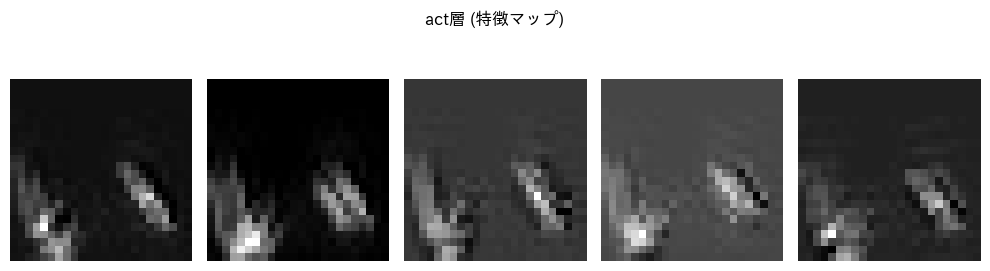

In [42]:
act_feature_map = feature_maps["act1"].squeeze().cpu().numpy()

fig, axes = plt.subplots(1, 5, figsize=(10, 3))
plt.suptitle('act層 (特徴マップ)')
for i, ax in enumerate(axes.flat):
    ax.imshow(act_feature_map[i], cmap="gray")
    ax.axis('off')
plt.tight_layout()
plt.show()

## 参考
* hookの削除と確認

In [34]:
# (オプション) hookの削除
# hookは一度登録すると、モデルのフォワードパスごとに呼び出されます。
# 不要になったら削除する　activation_outputsの値は削除されないよ
for hook in hooks:
    hook.remove()

# 再度フォワードパスを実行しても、activation_outputsは更新されない
feature_maps.clear() # 確認のためクリア
output_after_remove = model(sample_image)
print(f"feature_mapsの値が空っぽのはず：{feature_maps}")

feature_mapsの値が空っぽのはず：{}
